# League of Legends Champions' Characteristics with spaCy and Network Diagram with NetworkX in Python

Being tremendously inspired by the series Arcane, which was produced to perfection by Netflix and Riot Games in 2021, and the League of Legends World Championship 2023, which was my first League of Legends (LoL) tournament's viewership, I was dedicated to diving in the universe of this video game as it has proved to be a well-developed world with a massive character, or champion, list all interwining and connecting with each other. However, as my interest didn't include playing games and the universe of LoL was having over 160 champions by December of 2023, understanding characters' basic features and visualizing their complex networks could assist me with having a good grasp of their interwaeving worlds before jumping in the first storyline. 

Instead of relying on the summaries of the Fandom website, the analysis utilises the official sources, which are presented in https://universe.leagueoflegends.com/en_US/champions/. The process of scraping the website was performed by LOLWebScraping script, and the result was combined into a CSV file, 'lolstory.csv', comprising of 2 columns: the champions and their story. However, it is important to mention that the stories are only concerned with the champions's biographies and personal narratives texts. Other short stories were disregared as it required a considerable amount of work to scrutinise each champion's page to search for external anecdotes. Therefore, this analysis can be furthur developed in the future as possible completed study of the LoL universe.

Althogh several decisions being made throughout the process may not be perfect to decide the champions' dominant features and the weights of the relationships, I found the summaries useful and interesting to a certain extent. Before analysing the stories, I would like to present the final network visualization, which was run as a Python script, to serve as a clearer reference than the final result of this notebook.

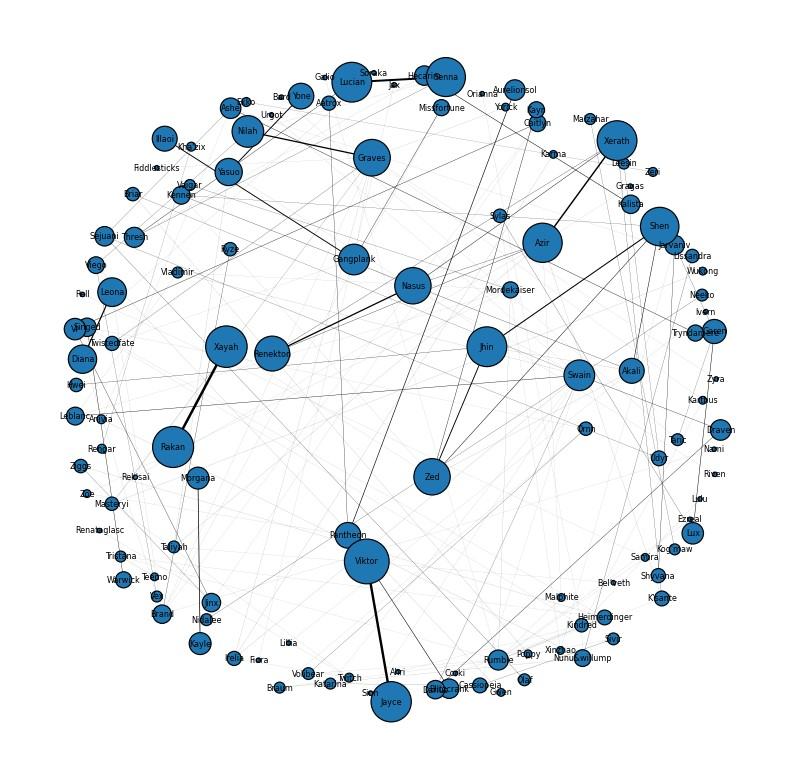

In [13]:
#Created by Trang Bui

In [14]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
import matplotlib.pyplot as plt

pandas was imported for easy manipulation of the relationships' weights, while spacy, CountVectorizer, and LatentDirichletAllocation was important for text processing and topic decisions. Networkx works off the Matplotlib, so both libraries were required for visualizing the network. 

The scraped stories included unrecognised symbols for pandas, so I would not be able read the CSV file using read_csv function. The text file was read manually and processed to fit in a dictionary that had the champions' names as the keys and the stories as the values.

In [15]:
champ_dict = {}
old_keys = []
new_keys = []
with open('lolstory.csv', 'r') as file:
    for line in file:
        key, value = line.strip().split(',', 1)
        if ' ' in key:
            old_keys.append(key)
            key = key.replace(' ', '')
            new_keys.append(key)
        champ_dict[key] = value

for key, value in champ_dict.items():
    for search_str, replace_str in zip(old_keys, new_keys):
        champ_dict[key] = value.replace(search_str, replace_str)
champ_dict

{'Aatrox': 'Whether mistaken for a demon or god, many tales have been told of the Darkin Blade... but few know his real name, or the story of his fall. In ancient times, long before desert sands swallowed the empire, a mighty champion of Shurima was brought before the Sun Disc to become the avatar for a now forgotten celestial ideal. Remade as one of the Ascended, his wings were the golden light of dawn, and his armor sparkled like a constellation of hope from beyond the great veil. Aatrox was his name. He was at the vanguard of every noble conflict. So true and just was his conduct that other god-warriors would always gather at his side, and ten thousand mortals of Shurima marched behind him. When Setaka, the Ascended warrior-queen, called for his help against the rebellion of Icathia, Aatrox answered without hesitation. But no one predicted the extent of the horrors that the rebels would unleash—the Void quickly overwhelmed its Icathian masters, and began the grinding annihilation of

League of Legends had several champions that has a space within their names such as Renata Glasc, Dr. Mundo, etc. These names would become an issue when the n-gram for the spacy model and CountVectorizer was 1, which means that each word is considered separately. To alleviate the problem, every space was removed from the champions' names, both in the keys and the values of the dictionary.

In [16]:
champ_topics = {}   
nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS 
entity_ruler = nlp.add_pipe("entity_ruler", before="ner")

patterns = [
    {
        "label": "CHAMP",
        "pattern": [
            {
                'LOWER': { 
                    'IN': [k.lower() for k, v in champ_dict.items()]
                }
            }
        ]
    }
]

entity_ruler.add_patterns(patterns)

spaCy is an advanced natural language processing library that supports named entity recognition, part-of-speech tagging, dependency parsing, sentence segmentation, text classification, lemmatization, morphological analysis, entity linking, etc. The language model for spaCy in this analysis was en_core_web_sm as it was a proficient and common spaCy English pipeline that can handle most documents efficiently. Additional information about spaCy's available models can be found here: https://spacy.io/models/en. To assist with the count of interactions between champions, I also added another label called "CHAMP" that included all champions' names so that spaCy could recognise the pattern in the text and classify correctly when it performed the Named Entity Recognition process (NER).

In [17]:
num_topics = 1
vectorizer = CountVectorizer()
lda = LatentDirichletAllocation(n_components = num_topics, random_state= 188)

The number of topics for each champion's text was 1. This might be inaccurate, but it could boost the processing time. Moreover, I only concerned the dominant topic, so choosing 1 might help the  model generalise the text better. CountVectorizer accepted a list of texts as input and produced a matrix of token counts as output. Latent Dirichlet allocation is a Bayesian network to extract topics in textual corpora. The model accepted the output from the CountVectorizer and derived the most dominant topic with highly decisive words from the text.

In [18]:
df_weight = pd.DataFrame(columns = [key.lower() for key in champ_dict.keys()], index = [key.lower() for key in champ_dict.keys()])
df_weight[:] = int(0)

df_weight was the matrix to contain the count of interactions between characters. In this case, as each text was specialised for each champion, I only counted the occurances of other champions in the text and considered it an interaction. This might not be enough as the other champions may just be mentioned in the text without being within the awareness of the target champion or the interactions between other characters with each other may not be counted, but for the moment, the analysis considered this approach as the main interactions between characters.

In [19]:
for key, value in champ_dict.items():
    #Processing text
    doc = nlp(value)
    lemmas = [token.lemma_ for token in doc]
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stopwords]
    text = ' '.join(a_lemmas)
    
    #Getting value for df_weight
    for champ in [ent.text for ent in doc.ents if ent.label_ == 'CHAMP' and ent.text.lower() != key.lower()]:
        df_weight[key.lower()][champ.lower()] += 1
        df_weight[champ.lower()][key.lower()] += 1
    
    #Finding the topic's words
    X = vectorizer.fit_transform([text])
    
    lda.fit_transform(X)

    feature_names = vectorizer.get_feature_names_out()
    top_words_idx = lda.components_[0].argsort()[:-7:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    if key.lower() in top_words:
        top_words.remove(key.lower())
    else:
        top_words.pop()
    champ_topics[key] = [', '.join(top_words)]

I looped through each item of the champions dictionary. The texts were processed by the spaCy model. The result from the model was processed by lemmatising, removing non-alphabetic tokens, and removing stopwords before being joined into a full text, which were later processed by CountVectorizer and Latent Dirichlet allocation to find the topic of the text. The final code was included to find the most appropriate words for the topic. As these words might include the champion's name, it was considered before being inserted into the dictionary.

In [20]:
champ_df = pd.DataFrame(champ_topics).T
print(champ_df)

                                               0
Aatrox     darkness, mortal, battle, form, shape
Ahri             life, come, memory, leave, feel
Akali          order, come, little, kinkou, shen
Akshan        bracelet, warlord, know, eye, girl
Alistar         ayelia, clan, leave, find, noxus
...                                          ...
Zeri              baron, people, know, like, man
Ziggs              bomb, flash, bang, wall, look
Zilean         icathia, great, mage, time, power
Zoe           girl, portal, aspect, away, mortal
Zyra     hatilly, cazworth, zychid, flower, vine

[166 rows x 1 columns]


The champions' topics were presented as above. It was displayed into a data frame for easy visualization.

In [21]:
max_value = df_weight.max().max()

# Custom function to sum columns excluding values where column index is equal to row index
def custom_sum(column, row_index):
    return column[column.index != row_index].sum()

# Summing across columns using apply and the custom function
node_weights = pd.Series({col: custom_sum(df_weight[col], col) for col in df_weight.columns})

df = df_weight.drop(list(node_weights[node_weights == 0].index), axis = 0)
df = df.drop(list(node_weights[node_weights == 0].index), axis = 1)

df = df/max_value

print(node_weights)

aatrox      7
ahri        1
akali      22
akshan      0
alistar     0
           ..
zeri        3
ziggs       6
zilean      0
zoe         2
zyra        1
Length: 166, dtype: int64


After obtaining the relationships' weights matrix, I used this matrix to visualise the network. Firstly, I needed to calculate the number of interactions that each champion had with the others and make these calculations the weights of the champions' nodes in the graph. This process could be done by summing the data frame across the row or column. In this case, I chose column. Even though I had made sure that the occurances beween the champion and itself would not be counted when I created the matrix, the custom_sum function would still be presented to furthur assure that the final result would not include these numbers in the calculation. The final matrix excluded every champions that didn't interact with the others for faster processing in later process. The weight matrix was also finalised in decimal form by dividing by max interaction.

In [22]:
edge_list = []
i = 0
for index, row in df.iterrows():
    j = i
    while j < len(df):
        edge_list.append((index.capitalize(), df.columns[j].capitalize(), round(row[j], 2)))
        j += 1
    i += 1

edge_list = [i for i in edge_list if i[2] != 0.0 and i[0] != i[1]]

max_occurance = max(node_weights)

node_list = [(champ.capitalize(), round(occurance/max_occurance, 2)) for champ, occurance in node_weights.items()]

node_list = [i for i in node_list if i[1] != 0]

I made 2 lists (edge_list and node_list) to submit to the graph's data. The edge list included all the information about the interactions between characters in the form of tuple: (character 1, character 2, relationship's weight). I iterated through the weight to append any possible relationships between characters to the list. i and j were custom variables to make sure that inversed relationships would not be included (so that the list didn't consist of both tuples (character 1, character 2, relationship's weight) and (character 2, character 1, relationship's weight) that pointed at the same relationship). I also made sure that no weight equalled 0 and character 1 was different from character 2 in the next step.

The node list included all the information about the champions' names and weights in the form of tuple: (character, node weight). I also concluded the weights to decimal form by dividing by the maximum weight. The next line of code assured that no weights equalled 0.

[('Aatrox', {'size': 0.1}), ('Ahri', {'size': 0.01}), ('Akali', {'size': 0.31}), ('Anivia', {'size': 0.04}), ('Ashe', {'size': 0.21}), ('Aurelionsol', {'size': 0.21}), ('Azir', {'size': 0.77}), ('Bard', {'size': 0.01}), ('Bel’veth', {'size': 0.01}), ('Blitzcrank', {'size': 0.19}), ('Brand', {'size': 0.17}), ('Braum', {'size': 0.06}), ('Briar', {'size': 0.09}), ('Caitlyn', {'size': 0.14}), ('Cassiopeia', {'size': 0.11}), ('Corki', {'size': 0.01}), ('Darius', {'size': 0.17}), ('Diana', {'size': 0.4}), ('Draven', {'size': 0.21}), ('Ekko', {'size': 0.04}), ('Ezreal', {'size': 0.01}), ('Fiddlesticks', {'size': 0.01}), ('Fiora', {'size': 0.01}), ('Galio', {'size': 0.01}), ('Gangplank', {'size': 0.47}), ('Garen', {'size': 0.29}), ('Gragas', {'size': 0.01}), ('Graves', {'size': 0.67}), ('Gwen', {'size': 0.03}), ('Hecarim', {'size': 0.19}), ('Heimerdinger', {'size': 0.11}), ('Hwei', {'size': 0.09}), ('Illaoi', {'size': 0.31}), ('Irelia', {'size': 0.1}), ('Ivern', {'size': 0.01}), ('Jarvaniv', {

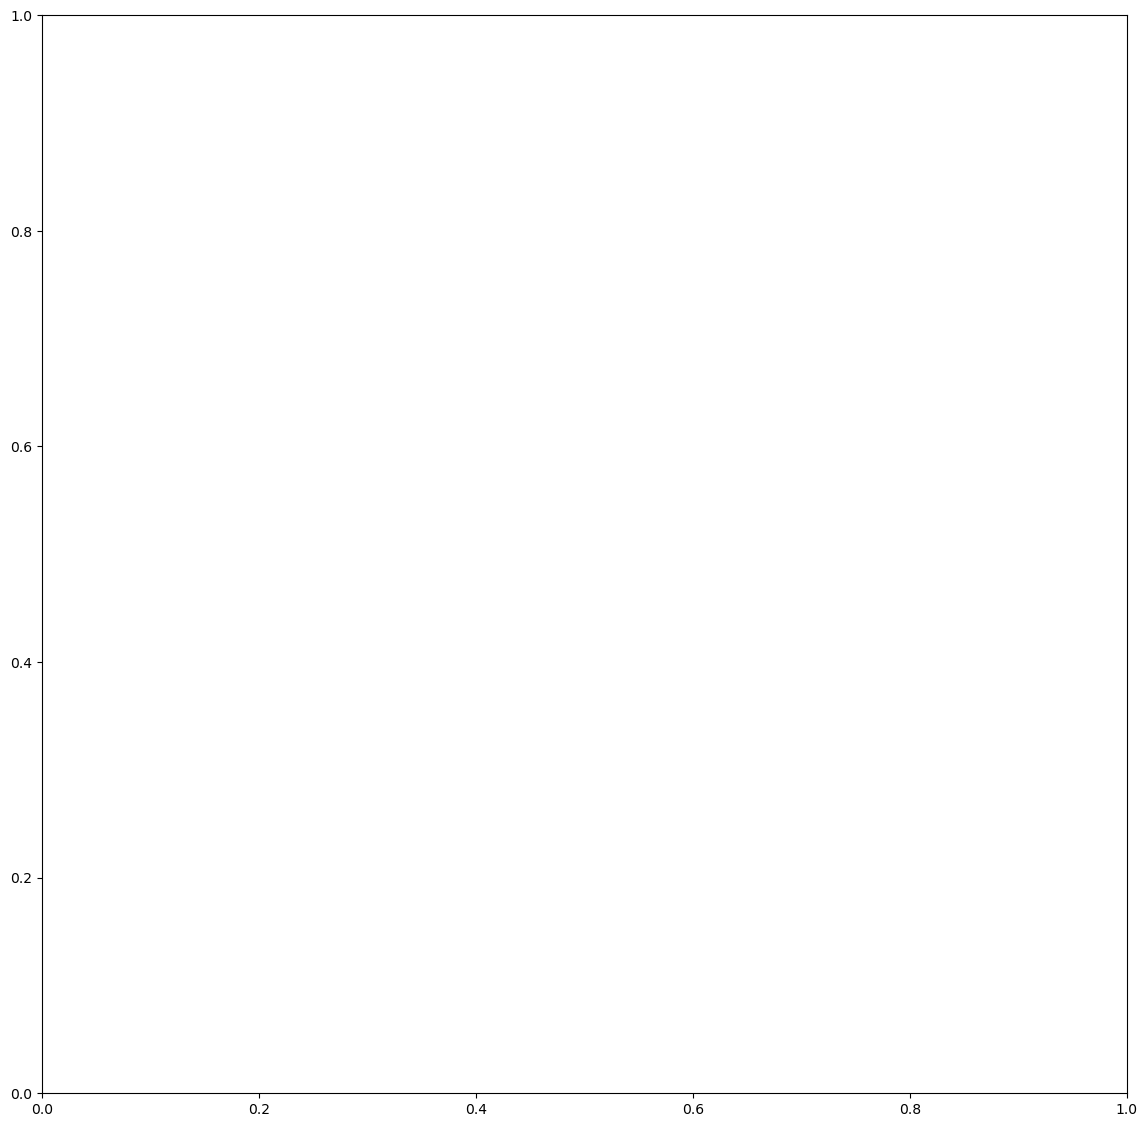

In [23]:
plt.subplots(figsize=(14,14))

G = nx.Graph()
for i in sorted(node_list):
    G.add_node(i[0], size = i[1])
G.add_weighted_edges_from(edge_list)

#Checking data of graphs
print(G.nodes(data=True))
print(G.edges(data=True))

The edge_list and node_list were submitted to the graph as data for the visualisation. I could examine the data by using the last 2 lines of code.

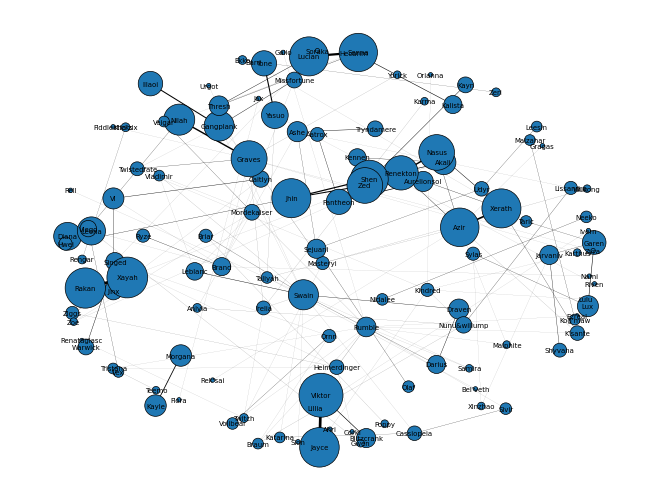

In [24]:
node_scalar = 1000
edge_scalar = 2
sizes = [i[1]*node_scalar for i in node_list]
widths = [i[2]*edge_scalar for i in edge_list]

pos = nx.spring_layout(G, k = 0.27, seed = 188)

nx.draw(G, pos, with_labels = True, font_size = 5, font_weight = 'light', node_size = sizes, width = widths, edgecolors = 'black', linewidths = 0.5)

plt.show()

The original sizes and weights were too small for visualisation, so I added scalars to explore possibilities with edges and nodes. The values were the result of many trial runs. The number of champions within the network was 126, so I manipulated the parameter k (to control the distance between 2 nodes of an edge) and seed (to produce the same visualization each run) of spring_layout to get the most pleasing visualisation.

This analysis can still be furthur extended with more accurate interpretations of interactions between characters, considering external short stories besides the champions' own stories, or shortening the list of champions in the network graph. At the moment, these developments will be left for future experience and interest. Overall, I was content with the result of this analysis, even though it may include several flaws and incompetencies, as I had fun experiencing a new Python package, NetworkX, with something I was interested in. 